# Challenge 7

- Buscar una base de datos de Physionet de imágenes médicas y extraer una porción de ellas (probablemente 50 imágenes de cada clase)
- Hacer una red neuronal multicapa grande para hacer la clasificación consideren usar 3 capas ocultas o más
- Luego prueban si hay overfitting, si hay, reducir la red, aplicar regularización y dropout en ese orden. Luego probar combinaciones entre ellas para mejorar el modelo. Verificar con funciones de pérdida o costo [min 20 epoc] y métrica accuracy.

In [1]:
from pydicom import dcmread
from sklearn.utils import resample
from cv2 import resize
from tqdm import tqdm
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [4]:
IMG_HEIGHT, IMG_WIDTH = 256, 256


def imageid2np(imageids: np.ndarray, path: str, lims: np.ndarray) -> np.ndarray:
    # from pydicom import dcmread

    # Se leen las imágenes y se retornan en un np.ndarray
    images = []
    for i in tqdm(range(len(imageids))):
        # print(imageids[i])
        image_path = f'{path}/{imageids[i]}.dicom'
        ds = dcmread(image_path)
        # Se normalizan las imágenes en base a su bit depth
        bitdepth_n = 2**ds.BitsStored - 1
        image = ds.pixel_array[lims[i,1]:lims[i,3],lims[i,0]:lims[i,2]]/bitdepth_n
        try:
            image = resize(image, (IMG_WIDTH, IMG_HEIGHT))
        except:
            print(imageids[i])
            print(np.shape(image))
            break
        images.append(image)
    # return images
    return np.array(images)


def process_csv(filename: str, random_state=42, minsize=None) -> tuple:
    # from sklearn.utils import resample

    csv = pd.read_csv(filename)
    csv2 = csv[['image_id', 'lesion_type', 'xmin', 'ymin', 'xmax', 'ymax']]

    # Se elimina other lesions ya que no necesariamente tienen características en común
    csv2 = csv2[csv2['lesion_type'] != 'Other lesions']
    # Se descarta no finding ya que no tienen anotaciones de posición
    csv2 = csv2[csv2['lesion_type'] != 'No finding']

    # Se hace un balanceo de la data
    # Para el training se usan 268
    # Para el testing se usan 69
    # 69/(69+268)=20.47%
    if not minsize:
        minority_class_size = csv2['lesion_type'].value_counts().min()
    else:
        # Sin embargo, el dataset es muy grande por la cantidad de imágenes
        minority_class_size = minsize
    classes = csv2['lesion_type'].unique()
    csv2_bal = pd.DataFrame()

    for c in classes:
        df_class = csv2[csv2['lesion_type'] == c]
        df_class_resampled = resample(
            df_class,
            replace=False,
            n_samples=minority_class_size,
            random_state=random_state,
        )
        csv2_bal = pd.concat([csv2_bal, df_class_resampled])

    X_ids = csv2_bal['image_id']
    X_ids = X_ids.values

    lims = csv2_bal[['xmin', 'ymin', 'xmax', 'ymax']]
    lims = lims.values
    lims = abs(lims.astype('int'))

    y = csv2_bal['lesion_type']
    # Se usa one-hot encoding para los labels
    y = pd.get_dummies(y)
    y = y.values

    fn_split = filename.split('/')
    img_folder = f'{fn_split[0]}/{fn_split[-1][:-4]}_images'

    # X_ids=X_ids[:10]
    # y=y[:10]

    X = imageid2np(X_ids, img_folder, lims)

    # Se retornan en np.ndarray
    return X, y

In [5]:
print('train')
X_train, y_train = process_csv('data_ch7/annotations/train.csv')  # ,minsize=160)
print('test')
X_test, y_test = process_csv('data_ch7/annotations/test.csv')  # ,minsize=40)

train


  0%|                                                                                          | 0/1608 [00:00<?, ?it/s]/home/pece/patrones/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1608/1608 [16:14<00:00,  1.65it/s]


test


  0%|                                                                                           | 0/414 [00:00<?, ?it/s]/home/pece/patrones/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████| 414/414 [04:03<00:00,  1.70it/s]


In [50]:
import pickle
with open('xy.pkl', 'wb') as f:
    pickle.dump([X_train, y_train, X_test, y_test], f)

In [1]:
import pickle
with open('xy.pkl', 'rb') as f:
# with open('D:/Users/USER/gits/patroneschallenges/xy.pkl', 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)

In [4]:
# for i in X_train:
#     print(np.shape(i))
#     plt.figure()
#     plt.imshow(i)
# for i in X_test:print(type(i))
# print(np.max(X_train))

## Modelo

Se utilizarán 100 epochs para evaluar el aprendizaje del modelo. Esto no significa que 100 epochs es el número ideal.

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-05-29 17:17:41.065673: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 17:17:41.125644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 17:17:41.700640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-29 17:17:42.586156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 17:17:42.666934: 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
print(X_train.shape)
print(y_train.shape)

(1608, 256, 256)
(1608, 6)


In [8]:
epochs = 100

In [21]:
from keras import regularizers

# Build the CNN model
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2],1), kernel_regularizer=regularizers.l1(0.01)), 
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
  MaxPooling2D((2, 2)),
  Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.5),
  Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/home/pece/patrones/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,585,670 (112.86 MB)

 Trainable params: 29,585,670 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1861 - loss: 2.9648

I0000 00:00:1717021511.721115   54530 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 68 bytes spill stores, 68 bytes spill loads



41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.1869 - loss: 2.9553 - val_accuracy: 0.0000e+00 - val_loss: 5.5687
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2906 - loss: 1.9992 - val_accuracy: 0.0683 - val_loss: 6.4059
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2874 - loss: 1.8296 - val_accuracy: 0.1211 - val_loss: 6.7910
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3210 - loss: 1.7447 - val_accuracy: 0.0994 - val_loss: 6.5481
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3584 - loss: 1.6407 - val_accuracy: 0.0932 - val_loss: 8.6541
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4469 - loss: 1.5489 - val_accuracy: 0.1398 - val_loss: 8.1078
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4029 - loss: 1.6075 - val_accuracy: 0.0994 - val_loss: 13.4993
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4424 - loss: 1.5206 - val_accuracy: 0.1149 - val_los

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5551 - loss: 1.1956 - val_accuracy: 0.1242 - val_loss: 13.1068
Epoch 18/20
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5773 - loss: 1.1615

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3273 - loss: 2.6049
Test accuracy: 0.39855071902275085


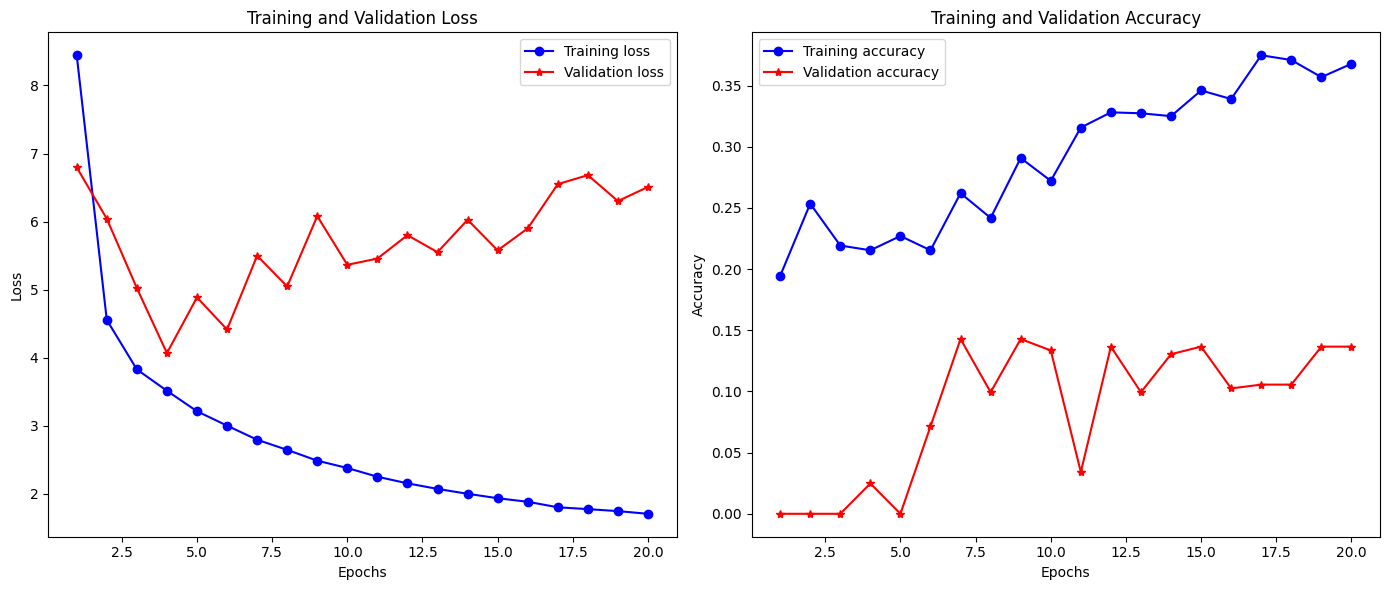

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable containing the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 6))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Modelo 2

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-05-29 17:40:54.191961: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 17:40:54.221316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 17:40:54.678756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-29 17:40:55.428490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 17:40:55.456184: 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import kerastuner as kt
# from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os


In [13]:
# Define the model-building function for the tuner
def constructor_modelos(hp):
    model = tf.keras.Sequential()
    
    # First Conv layer
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2], 1),
        kernel_regularizer=regularizers.l1(0.01)
    ))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    # Second Conv layer
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    # Third Conv layer
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    
    # Dense layer
    hp_units = hp.Int("units", min_value=128, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(
        units=hp_units,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-5)
    ))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Output layer for binary classification (change activation to 'softmax' if multi-class classification)
    model.add(tf.keras.layers.Dense(
        units=y_train.shape[1],
        activation='softmax'
    ))
    
    # Compile model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model



# Search for the best hyperparameters
# tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

In [15]:
import kerastuner as kt
from kerastuner.tuners import Hyperband
# Set up the tuner
tuner = Hyperband(
    constructor_modelos,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='modelos/',
    project_name='modelo2'
)

In [16]:
history=tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Trial 15 Complete [00h 00m 17s]

Best val_accuracy So Far: 0.16149067878723145
Total elapsed time: 00h 07m 24s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
64                |128               |conv_1_filters
96                |96                |conv_2_filters
128               |96                |conv_3_filters
352               |448               |units
0.001             |0.001             |learning_rate
7                 |3                 |tuner/epochs
3                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
1                 |0                 |tuner/round
0001              |None              |tuner/trial_id

